In [42]:
#!pip install scikit-bio
#!pip install scikit-learn
#!pip install plotly
#!pip install dash
#!pip install seaborn
# For Correspondence Analysis (CA)
#!pip install prince
#!pip uninstall -y prince
#!pip install prince
#!pip install --upgrade typing_extensions
#!pip install --force-reinstall typing_extensions==4.5.0

# tqdm in Jupyter uses a widget-based progress bar (IProgress), which needs ipywidgets installed and enabled
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 428.6 kB/s eta 0:00:00a 0:00:01


In [7]:
# Goal: Create a Taxon × Habitat Abundance Table
# Each row = a Taxon
# Each column = a Habitat (from 'Pre: Transect physical habitat')
# Each cell = # of occurrences of that taxon in that habitat

In [12]:
# Step 1: Load Pickle Files
import pandas as pd

# Load the pickled data
df_transects = pd.read_pickle("../data/pkl/df_transects.pkl")
df_occurrences_with_taxon = pd.read_pickle("../data/pkl/df_occurrences_with_taxon.pkl")
df_taxon_by_habitat = pd.read_pickle("../data/pkl/df_taxon_by_habitat.pkl")
df_taxon_by_transect = pd.read_pickle("../data/pkl/df_taxon_by_transect.pkl")


In [14]:
# Step 2: Filter to Old Reserve Only
# Filter occurrences to only those on the old reserve
# Filter transects excluding year 2008 and most 2024 transects (keep 2024 'shrubs closed')
# Filter transects to only those marked as "on old reserve"
df_transects['Year'] = pd.to_datetime(df_transects['start_time']).dt.year
mask_not_2008 = df_transects['Year'] != 2008
mask_keep_2024 = ~((df_transects['Year'] == 2024) & (df_transects['Pre: Transect physical habitat'] != 'shrubs closed'))
df_filtered_transects = df_transects[mask_not_2008 & mask_keep_2024].copy()

df_old_reserve_transects = df_filtered_transects[df_filtered_transects["Pre: On old reserve?"] == "Yes"].copy()
valid_transect_uids = df_old_reserve_transects['UID']

#df_occ_old_reserve = df_occurrences_with_taxon[
#    df_occurrences_with_taxon['Pre: On old reserve?'] == 'Yes'
#].copy()

df_occ_old_reserve = df_occurrences_with_taxon[
    df_occurrences_with_taxon['UID'].isin(valid_transect_uids)
].copy()
#df_occ_old_reserve.head()

In [15]:
# Step 3: Build Taxon Abundance Table by Habitat
# Pivot table: Taxa x Habitat (Old Reserve only)
df_taxon_by_habitat_old_reserve = df_occ_old_reserve.pivot_table(
    index='Taxon Label',
    columns='Pre: Transect physical habitat',
    values='ID',
    aggfunc='count',
    fill_value=0
)

# Sort by total abundance across all habitats
df_taxon_by_habitat_old_reserve['Total'] = df_taxon_by_habitat_old_reserve.sum(axis=1)
df_taxon_by_habitat_old_reserve = df_taxon_by_habitat_old_reserve.sort_values('Total', ascending=False)
df_taxon_by_habitat_old_reserve.drop(columns='Total', inplace=True)


In [11]:
# Step 4: Preview the Table
import pandas as pd
from IPython.display import display

# Display top rows
display(df_taxon_by_habitat_old_reserve.head(10))


Pre: Transect physical habitat,grass closed,shrubs closed,shrubs open,trees closed
Taxon Label,,,,
Mammalia indet,67,39,74,7
zebra,73,14,52,6
warthog,18,1,20,1
Bovidae (medium),16,4,15,2
Bovidae (large),11,11,13,0
Bovidae (small),15,7,7,2
giraffe,11,6,7,0
Thompson's gazelle,11,0,4,0
impala,3,1,7,4


In [14]:
# 2. Diversity Metrics by Habitat
# Metric	Description
# Richness	Number of unique taxa
# Shannon Index	Takes into account both richness and evenness
# Simpson Index	Probability that two individuals belong to same taxon
# Evenness	How evenly individuals are distributed among taxa

In [16]:
# Step 1: Create Taxon Abundance Table (Old Reserve Only)
df_taxon_by_habitat_old_reserve = df_occ_old_reserve.pivot_table(
    index='Taxon Label',
    columns='Pre: Transect physical habitat',
    values='ID',
    aggfunc='count',
    fill_value=0
)

# Step 2: Calculate Diversity Metrics
import numpy as np
import pandas as pd

diversity_metrics = {}

for habitat in df_taxon_by_habitat_old_reserve.columns:
    counts = df_taxon_by_habitat_old_reserve[habitat]
    total = counts.sum()
    
    # Richness (number of taxa with at least 1 occurrence)
    richness = (counts > 0).sum()
    
    # Relative abundances (p_i)
    proportions = counts[counts > 0] / total
    
    # Shannon Index
    shannon = -np.sum(proportions * np.log(proportions))
    
    # Simpson Index
    simpson = np.sum(proportions**2)
    
    # Evenness (Shannon / ln(Richness))
    evenness = shannon / np.log(richness) if richness > 1 else 0
    
    diversity_metrics[habitat] = {
        'Richness': richness,
        'Shannon Index': round(shannon, 3),
        'Simpson Index': round(simpson, 3),
        'Evenness': round(evenness, 3)
    }

# Convert to DataFrame
df_diversity = pd.DataFrame(diversity_metrics).T

# Preview the Results
df_diversity

# Interpretation of Diversity Metrics
# Metric	What It Tells You
# Richness	Number of different taxa observed (doesn’t consider abundance)
# Shannon	Diversity accounting for richness + evenness
# Simpson	Lower = more diverse (probability 2 individuals are same taxon)
# Evenness	How equally individuals are distributed across taxa

,Richness,Shannon Index,Simpson Index,Evenness
grass closed,17.0,2.063,0.187,0.728
shrubs closed,14.0,1.984,0.214,0.752
shrubs open,15.0,1.962,0.203,0.725
trees closed,9.0,1.997,0.158,0.909


In [16]:
# Key Observations
# Grass Closed
# Highest richness (17 taxa)
# Shannon: 2.06 → fairly high diversity
# Evenness: 0.73 → moderately balanced

# Trees Closed
# Lowest richness (9 taxa), but Shannon is almost the highest (2.00)
# Evenness: 0.91 → very evenly distributed community
# Suggests few taxa, but well-balanced

# Shrubs Closed/Open
# Similar diversity profiles, slightly lower richness
# Good evenness and moderately low Simpson Index

In [18]:
# 3. Ordination (Community Composition)
# Samples as rows, taxa as columns
# Step 1: Transpose to Habitat x Taxa Matrix
df_composition = df_taxon_by_habitat_old_reserve.T
df_composition.head()


Taxon Label,,Aves (medium),Aves (small),Bovidae (large),Bovidae (medium),Bovidae (small),Grant's gazelle,Mammalia indet,Rhinocerotidae,Thompson's gazelle,...,elephant,giraffe,hare,hartebeest,impala,spotted hyaena,ungulate,warthog,waterbuck,zebra
Pre: Transect physical habitat,,,,,,,,,,,,,,,,,,,,,
grass closed,6,1,0,11,16,15,4,67,0,11,...,0,11,0,2,3,0,0,18,1,73
shrubs closed,0,1,1,11,4,7,0,39,0,0,...,0,6,0,0,1,0,2,1,4,14
shrubs open,0,0,1,13,15,7,1,74,1,4,...,0,7,0,0,7,1,0,20,0,52
trees closed,0,0,0,0,2,2,0,7,0,0,...,2,0,1,0,4,0,0,1,3,6


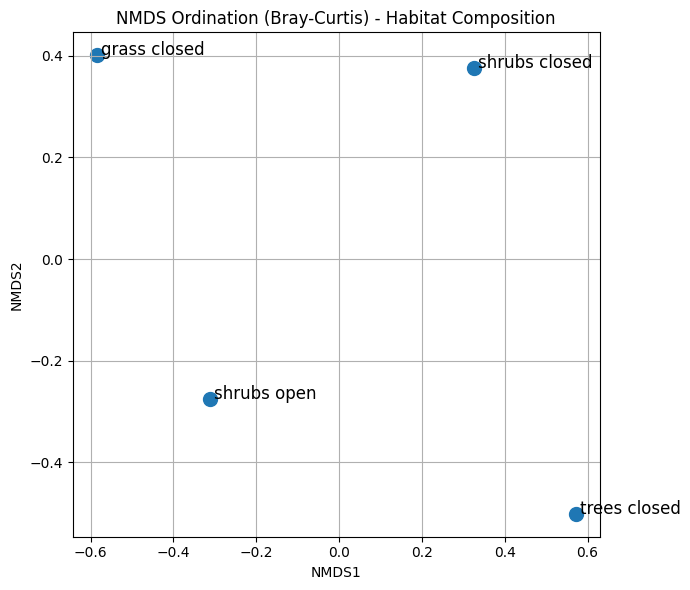

In [19]:
# Step 2: Run NMDS with Bray-Curtis
# Step 2.1: Bray-Curtis Distance
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import pandas as pd
import matplotlib.pyplot as plt

# Use habitat x taxa matrix, df_composition
# Compute Bray-Curtis dissimilarity
bray_curtis = pdist(df_composition.values, metric="braycurtis")
bc_matrix = squareform(bray_curtis)

# Step 2.2: Run NMDS (non-metric MDS)
nmds = MDS(
    n_components=2,
    dissimilarity="precomputed",
    metric=False,
    random_state=42,
    max_iter=1000,
    eps=1e-9,
    n_init=10
)

nmds_coords = nmds.fit_transform(bc_matrix)
nmds_df = pd.DataFrame(nmds_coords, columns=["NMDS1", "NMDS2"], index=df_composition.index)

# Step 2.3: Plot It
plt.figure(figsize=(7, 6))
plt.scatter(nmds_df["NMDS1"], nmds_df["NMDS2"], s=100)

for label, (x, y) in nmds_df.iterrows():
    plt.text(x + 0.01, y, label, fontsize=12)

plt.title("NMDS Ordination (Bray-Curtis) - Habitat Composition")
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# NMDS is non-metric, so unlike PCA, it doesn't naturally produce loadings (i.e. variable contributions to axes), because:
# NMDS doesn't use the original variable space — it uses distances between samples only.
# However, you can still estimate which taxa are associated with NMDS axes by calculating correlations between species abundances and NMDS scores.
# This is similar to what envfit does in R (vegan package).

# Step-by-Step: Simulate NMDS "Loadings" via Correlation
# 1. Start from the matrices
# Habitat x Taxa matrix
df_composition = df_taxon_by_habitat_old_reserve.T

# NMDS coordinates (habitat rows)
nmds_df  # contains columns "NMDS1", "NMDS2" and index = habitat names

,NMDS1,NMDS2
Pre: Transect physical habitat,,
grass closed,-0.585070,0.401048
shrubs closed,0.325107,0.375693
shrubs open,-0.311151,-0.275759
trees closed,0.571115,-0.500982


In [22]:
# 2. Compute Pearson correlations between taxa and NMDS axes
from scipy.stats import pearsonr
import pandas as pd

loadings = {}

for taxon in df_composition.columns:
    taxon_abund = df_composition[taxon]
    r1, _ = pearsonr(taxon_abund, nmds_df["NMDS1"])
    r2, _ = pearsonr(taxon_abund, nmds_df["NMDS2"])
    loadings[taxon] = {"NMDS1": r1, "NMDS2": r2}

df_loadings = pd.DataFrame(loadings).T

# Result: df_loadings
# Each row = taxon
# Each column = correlation with NMDS axis
df_loadings

,NMDS1,NMDS2
,-0.723888,0.583898
Aves (medium),-0.278552,0.979371
Aves (small),0.014954,0.126004
Bovidae (large),-0.722858,0.610960
Bovidae (medium),-0.985282,0.278321
Bovidae (small),-0.866977,0.773434
Grant's gazelle,-0.866503,0.510866
Mammalia indet,-0.923520,0.420141
Rhinocerotidae,-0.384977,-0.401485
Thompson's gazelle,-0.915809,0.464227


In [23]:
# Optional: Show Top Taxa per Axis
df_loadings.abs().sort_values("NMDS1", ascending=False).head(10)


,NMDS1,NMDS2
zebra,0.994533,0.395163
Bovidae (medium),0.985282,0.278321
warthog,0.941099,0.110225
Mammalia indet,0.923520,0.420141
Thompson's gazelle,0.915809,0.464227
giraffe,0.906735,0.758280
Bovidae (small),0.866977,0.773434
Grant's gazelle,0.866503,0.510866
waterbuck,0.822939,0.159837
hartebeest,0.723888,0.583898


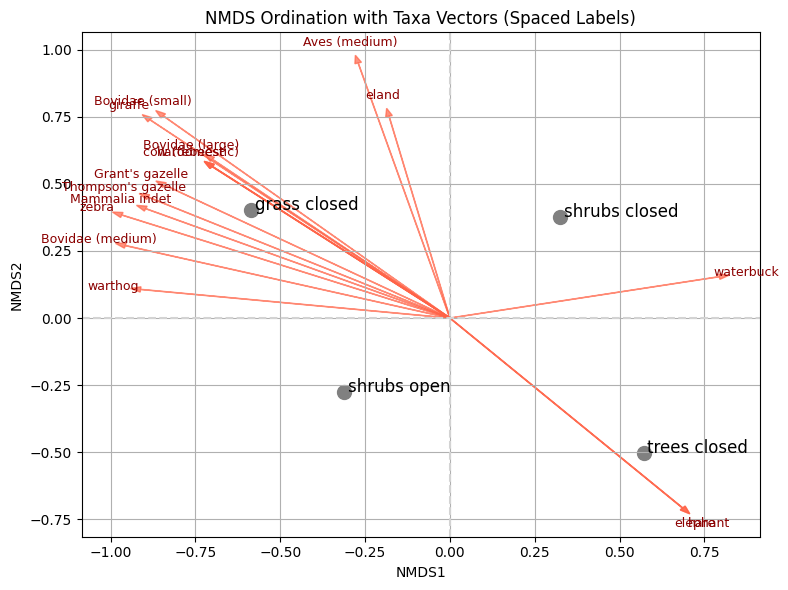

In [24]:
# Step-by-Step: Taxa Vectors on NMDS Ordination
# 1. Correlate Taxa with NMDS Axes

from scipy.stats import pearsonr
import pandas as pd

loadings = {}

for taxon in df_composition.columns:
    taxon_abund = df_composition[taxon]
    r1, _ = pearsonr(taxon_abund, nmds_df["NMDS1"])
    r2, _ = pearsonr(taxon_abund, nmds_df["NMDS2"])
    loadings[taxon] = {"NMDS1": r1, "NMDS2": r2}

df_loadings = pd.DataFrame(loadings).T

# 2. Clean + Filter (Optional)
threshold = 0.7
df_loadings_filtered = df_loadings[df_loadings.abs().max(axis=1) > threshold]

# 3. Plot NMDS with Taxa Vectors
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Plot habitat points
plt.scatter(nmds_df["NMDS1"], nmds_df["NMDS2"], s=100, color='gray')
for label, (x, y) in nmds_df.iterrows():
    plt.text(x + 0.01, y, label, fontsize=12)

# Plot taxa vectors with adjusted labels
for taxon, row in df_loadings_filtered.iterrows():
    x, y = row["NMDS1"], row["NMDS2"]
    
    # Arrow
    plt.arrow(0, 0, x, y, color='tomato', alpha=0.7, head_width=0.02, length_includes_head=True)
    
    # Label offset: radial direction
    angle = np.arctan2(y, x)
    label_x = x + 0.05 * np.cos(angle)
    label_y = y + 0.05 * np.sin(angle)
    
    plt.text(label_x, label_y, taxon, fontsize=9, color='darkred', ha='center', va='center')

# Axes
plt.axhline(0, color='lightgray', linestyle='--')
plt.axvline(0, color='lightgray', linestyle='--')

plt.title("NMDS Ordination with Taxa Vectors (Spaced Labels)")
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.grid(True)
plt.tight_layout()
plt.show()

# What You Now Have
# Points = habitats on NMDS axes
# Arrows = taxa correlated with the axes (like PCA biplots)
# Length/direction = strength & association with ordination

In [28]:
# Step-by-Step: Interactive NMDS Biplot with Plotly
# Create Interactive Plot
import plotly.graph_objects as go

# NMDS habitat points
points = go.Scatter(
    x=nmds_df["NMDS1"],
    y=nmds_df["NMDS2"],
    mode='markers+text',
    name='Habitats',
    text=nmds_df.index,
    textposition='top center',
    marker=dict(size=10, color='gray'),
    hoverinfo='text'
)

# Taxa vectors as arrows
vectors = []
for taxon, row in df_loadings_filtered.iterrows():
    x, y = row["NMDS1"], row["NMDS2"]
    
    # Arrow line
    vectors.append(
        go.Scatter(
            x=[0, x],
            y=[0, y],
            mode='lines+text',
            line=dict(color='tomato', width=2),
            text=[None, taxon],
            textposition='top right',
            textfont=dict(size=10, color='darkred'),
            hoverinfo='text',
            showlegend=False
        )
    )

# Combine all traces
fig = go.Figure(data=[points] + vectors)

# Layout settings
fig.update_layout(
    title="Interactive NMDS Ordination with Taxa Vectors",
    xaxis_title="NMDS1",
    yaxis_title="NMDS2",
    width=800,
    height=700,
    showlegend=False
)

fig.show()


In [31]:
# But both PCA and CA require:
# Samples as rows, taxa as columns
# So let’s first transpose:
df_matrix = df_taxon_by_habitat_old_reserve.T  # shape: habitats × taxa

In [32]:
# Part 1: PCA
# We’ll standardize and run PCA on the habitat × taxa matrix.
# Step 1: Run PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_matrix)

# Run PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(df_scaled)

# Pack into DataFrame
df_pca = pd.DataFrame(pca_coords, columns=['PC1', 'PC2'], index=df_matrix.index)

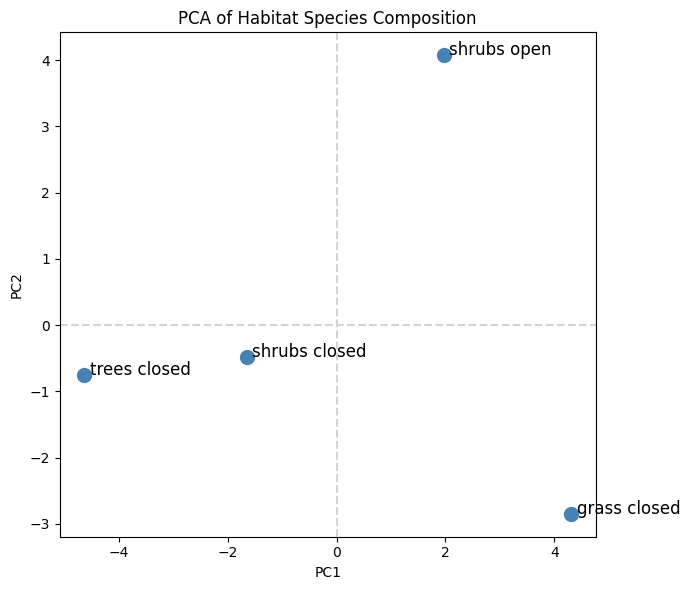

In [33]:
# Step 2: Plot PCA
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.scatter(df_pca["PC1"], df_pca["PC2"], s=100, color="steelblue")

for label, (x, y) in df_pca.iterrows():
    plt.text(x + 0.1, y, label, fontsize=12)

plt.axhline(0, color='lightgray', linestyle='--')
plt.axvline(0, color='lightgray', linestyle='--')
plt.title("PCA of Habitat Species Composition")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [36]:
# Part 2: Correspondence Analysis (CA)
# CA is a better fit for count data, and it doesn’t require standardization.

# Step 1: Run CA
import prince

# Initialize and fit CA
ca = prince.CA(n_components=2, random_state=42)
ca = ca.fit(df_matrix)

# Get CA coordinates
df_ca_habitats = ca.row_coordinates(df_matrix)     # habitats (samples)
df_ca_taxa = ca.column_coordinates(df_matrix)      # taxa (features)


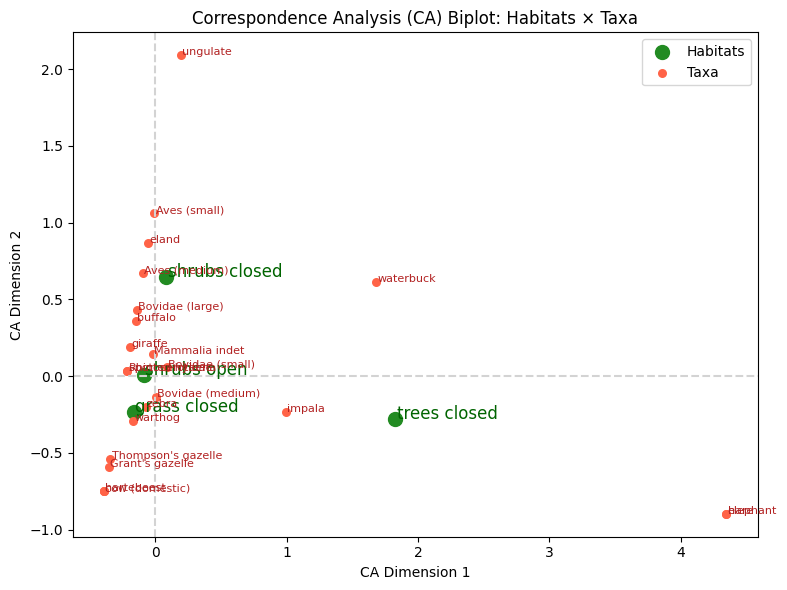

In [37]:
# Step 2: Plot CA Biplot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot habitats
plt.scatter(df_ca_habitats[0], df_ca_habitats[1], s=100, color='forestgreen', label='Habitats')
for label, (x, y) in df_ca_habitats.iterrows():
    plt.text(x + 0.01, y, label, fontsize=12, color='darkgreen')

# Plot taxa
plt.scatter(df_ca_taxa[0], df_ca_taxa[1], s=30, color='tomato', label='Taxa')
for label, (x, y) in df_ca_taxa.iterrows():
    plt.text(x + 0.01, y, label, fontsize=8, color='firebrick')

# Axes and title
plt.axhline(0, color='lightgray', linestyle='--')
plt.axvline(0, color='lightgray', linestyle='--')
plt.xlabel("CA Dimension 1")
plt.ylabel("CA Dimension 2")
plt.title("Correspondence Analysis (CA) Biplot: Habitats × Taxa")
plt.legend()
plt.tight_layout()
plt.show()

# What This Shows
# Habitats are positioned based on taxonomic composition
# Taxa are positioned based on their association with habitats
# Closeness between a habitat and a taxon suggests higher frequency or strong association

In [29]:
# Main Step 4: Dissimilarity & Clustering
# We'll build:
# A dissimilarity matrix (Bray-Curtis or Jaccard)
# A clustering dendrogram to visualize community similarity
# Optional: Heatmaps, cluster overlays, cophenetic correlation

In [38]:
# 1. Data to Use
# You can use the habitat × taxon matrix we built earlier:
df_matrix = df_taxon_by_habitat_old_reserve.T  # shape: habitats × taxa

# Each row = one habitat
# Each column = species (counts)

In [39]:
# Step 1: Compute Bray-Curtis Dissimilarity Matrix
from scipy.spatial.distance import pdist, squareform

# Bray-Curtis dissimilarity
bray_dist = pdist(df_matrix.values, metric='braycurtis')
bray_square = squareform(bray_dist)

# Wrap into DataFrame
import pandas as pd
df_bray = pd.DataFrame(bray_square, index=df_matrix.index, columns=df_matrix.index)


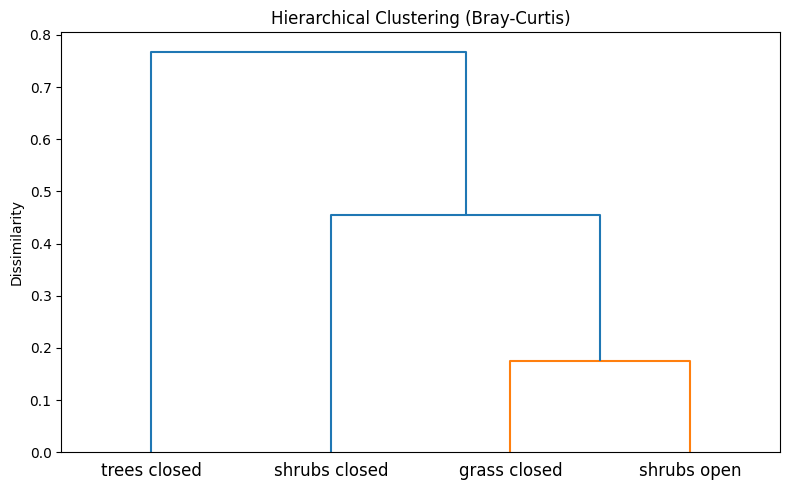

In [40]:
# Step 2: Hierarchical Clustering & Dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform clustering
linkage_matrix = linkage(bray_dist, method='average')  # 'average' = UPGMA

# Plot dendrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix, labels=df_matrix.index, color_threshold=0.3)
plt.title("Hierarchical Clustering (Bray-Curtis)")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()

# Interpretation
# Dendrogram branches closer together = more similar habitats

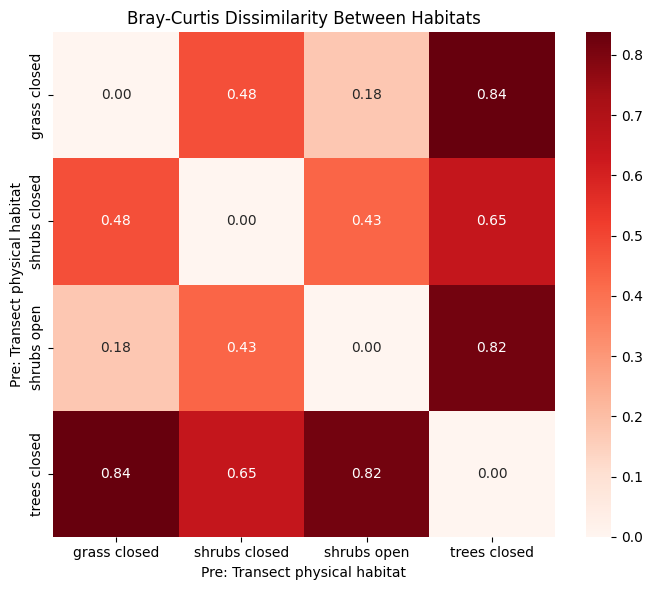

In [43]:
# Step 3 (Optional): Heatmap of Dissimilarity
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.heatmap(df_bray, cmap="Reds", annot=True, fmt=".2f")
plt.title("Bray-Curtis Dissimilarity Between Habitats")
plt.tight_layout()
plt.show()

# Interpretation
# Bray-Curtis values:
# 0.0 = identical
# 1.0 = completely different

In [34]:
# Main step 5. Indicator Species Analysis
# What Is Indicator Species Analysis?
# Indicator species analysis identifies which taxa are strongly associated with particular habitats (or any grouping). A taxon is considered a good "indicator" if it's:
# Common (high abundance) in a group
# Faithful (mostly found only in that group)

# Step-by-Step Plan
# Since indicspecies (in R) is the go-to package, we'll use a Python-compatible version based on:
# Grouped presence/absence or count data
# Calculate Indicator Value (IndVal) = specificity × fidelity
# Use permutation testing for significance
# We’ll use:
# df_matrix → habitats × taxa (counts)
# Habitat labels for grouping

In [44]:
# Step 1: Prepare Data
# We’ll convert count data to presence/absence for this example:
df_pa = df_matrix.copy()
df_pa[df_pa > 0] = 1  # convert to binary (presence/absence)

In [45]:
# Step 2: Prepare Group Labels
habitats = df_pa.index.to_list()

In [46]:
# Step 3: Define Indicator Value Function
import numpy as np

def indval(df, groups):
    results = []

    group_names = sorted(set(groups))

    for species in df.columns:
        species_data = df[species]
        
        indval_scores = {}
        for group in group_names:
            group_mask = [g == group for g in groups]
            in_group = species_data[group_mask]
            out_group = species_data[~np.array(group_mask)]

            # Specificity (A)
            A = in_group.sum() / species_data.sum() if species_data.sum() > 0 else 0

            # Fidelity (B)
            B = (in_group > 0).sum() / sum(group_mask)

            # IndVal
            indval = A * B
            indval_scores[group] = indval

        best_group = max(indval_scores, key=indval_scores.get)
        best_score = indval_scores[best_group]

        results.append({
            'Species': species,
            'Best Group': best_group,
            'IndVal': round(best_score, 3),
        })

    return pd.DataFrame(results)


In [47]:
# Step 4: Run Indicator Value Analysis
df_indicators = indval(df_pa, habitats)

# Sort by highest IndVal
df_indicators = df_indicators.sort_values(by="IndVal", ascending=False)
df_indicators.head(10)


,Species,Best Group,IndVal
0,,grass closed,1.0
18,spotted hyaena,shrubs open,1.0
19,ungulate,shrubs closed,1.0
15,hare,trees closed,1.0
13,elephant,trees closed,1.0
11,cow (domestic),grass closed,1.0
8,Rhinocerotidae,shrubs open,1.0
16,hartebeest,grass closed,1.0
1,Aves (medium),grass closed,0.5
2,Aves (small),shrubs closed,0.5


In [39]:
# Step-by-Step: Full Indicator Species Analysis
# We’ll use:
# df_matrix → habitats × taxa (from earlier)
# Presence/absence or count (we’ll use presence/absence here)
# 999 permutations for p-values

In [48]:
# Step 1: Prepare Data
# Presence/absence matrix: 1 = present, 0 = absent
df_pa = df_matrix.copy()
df_pa[df_pa > 0] = 1

# Group labels = habitat names (assumes index of df_pa is habitat)
groups = df_pa.index.to_list()


In [58]:
# Step 2: Define IndVal + Permutation Test
import numpy as np
import pandas as pd
# from tqdm.notebook import tqdm
from tqdm import tqdm

def compute_indval(df, groups):
    group_names = sorted(set(groups))
    result_rows = []

    for species in df.columns:
        species_data = df[species]
        best_group = None
        best_score = 0

        for group in group_names:
            mask = np.array([g == group for g in groups])
            in_group = species_data[mask]
            out_group = species_data[~mask]

            A = in_group.sum() / species_data.sum() if species_data.sum() > 0 else 0
            B = (in_group > 0).sum() / mask.sum()
            score = A * B

            if score > best_score:
                best_score = score
                best_group = group

        result_rows.append({
            'Species': species,
            'Best Group': best_group,
            'IndVal': best_score
        })

    return pd.DataFrame(result_rows)

def permute_p_values(df, groups, observed, n_perm=999):
    p_values = []

    for _, row in tqdm(observed.iterrows(), total=len(observed)):
        species = row['Species']
        obs_val = row['IndVal']

        null_vals = []
        for _ in range(n_perm):
            shuffled_groups = np.random.permutation(groups)
            perm_result = compute_indval(df[[species]], shuffled_groups)
            null_val = perm_result.iloc[0]['IndVal']
            null_vals.append(null_val)

        # p = proportion of null values >= observed
        p = (np.sum(np.array(null_vals) >= obs_val) + 1) / (n_perm + 1)
        p_values.append(p)

    observed['p-value'] = p_values
    return observed

In [59]:
# Step 3: Run Analysis
df_indicators = compute_indval(df_pa, groups)
df_indicators = permute_p_values(df_pa, groups, df_indicators)


100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


In [60]:
df_indicators

,Species,Best Group,IndVal,p-value
0,,grass closed,1.000000,1.0
1,Aves (medium),grass closed,0.500000,1.0
2,Aves (small),shrubs closed,0.500000,1.0
3,Bovidae (large),grass closed,0.333333,1.0
4,Bovidae (medium),grass closed,0.250000,1.0
5,Bovidae (small),grass closed,0.250000,1.0
6,Grant's gazelle,grass closed,0.500000,1.0
7,Mammalia indet,grass closed,0.250000,1.0
8,Rhinocerotidae,shrubs open,1.000000,1.0
9,Thompson's gazelle,grass closed,0.500000,1.0


In [61]:
# Step 4: Filter Significant Indicators
df_indicators_sig = df_indicators[df_indicators['p-value'] <= 0.05]
df_indicators_sig = df_indicators_sig.sort_values('IndVal', ascending=False)
df_indicators_sig.head(10)

,Species,Best Group,IndVal,p-value


/tmp/ipykernel_266/3743845541.py:18: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



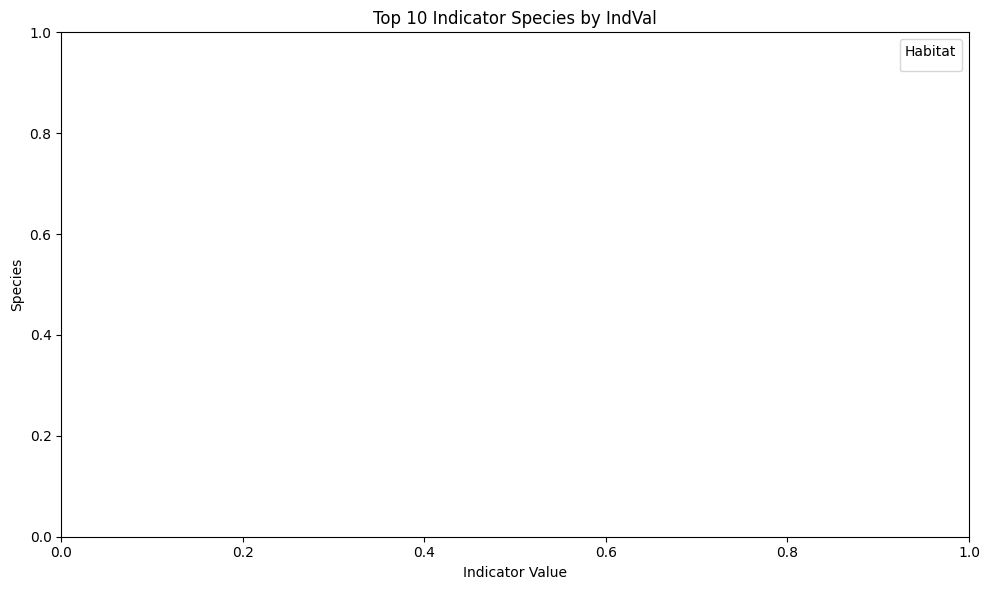

In [62]:
# Step 5: Bar Plot of Top Indicators
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_indicators_sig.head(top_n),
    y="Species",
    x="IndVal",
    hue="Best Group",
    dodge=False
)
plt.title(f"Top {top_n} Indicator Species by IndVal")
plt.xlabel("Indicator Value")
plt.ylabel("Species")
plt.xlim(0, 1)
plt.legend(title="Habitat")
plt.tight_layout()
plt.show()
